In [33]:
import math
import torch

# use a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float

In [34]:
# use regular spaced points on the interval [0, 1]
train_X = torch.linspace(0, 1, 15, dtype=dtype, device=device)
# training data needs to be explicitly multi-dimensional
train_X = train_X.unsqueeze(1)

# sample observed values and add some synthetic noise
train_Y = torch.sin(train_X * (2 * math.pi)) + 0.15 * torch.randn_like(train_X)

In [35]:
from botorch.models import SingleTaskGP
from gpytorch.constraints import GreaterThan


model = SingleTaskGP(train_X=train_X, train_Y=train_Y)
model.likelihood.noise_covar.register_constraint("raw_noise", GreaterThan(1e-5))

In [36]:
from gpytorch.mlls import ExactMarginalLogLikelihood

mll = ExactMarginalLogLikelihood(likelihood=model.likelihood, model=model)
# set mll and all submodules to the specified dtype and device
mll = mll.to(train_X)

In [41]:
from torch.optim import SGD

print(model.parameters())
optimizer = SGD([{'params': model.parameters()}], lr=0.1)

<generator object Module.parameters at 0x14ac88970>


In [38]:
NUM_EPOCHS = 150

model.train()

for epoch in range(NUM_EPOCHS):
    # clear gradients
    optimizer.zero_grad()
    # forward pass through the model to obtain the output MultivariateNormal
    output = model(train_X)
    # Compute negative marginal log likelihood
    loss = - mll(output, model.train_targets)
    # back prop gradients
    loss.backward()
    # print every 10 iterations
    if (epoch + 1) % 10 == 0:
        print(
            f"Epoch {epoch+1:>3}/{NUM_EPOCHS} - Loss: {loss.item():>4.3f} "
            f"lengthscale: {model.covar_module.base_kernel.lengthscale.item():>4.3f} " 
            f"noise: {model.likelihood.noise.item():>4.3f}" 
         )
    optimizer.step()

Epoch  10/150 - Loss: 1.938 lengthscale: 0.648 noise: 1.998
Epoch  20/150 - Loss: 1.900 lengthscale: 0.605 noise: 1.853
Epoch  30/150 - Loss: 1.862 lengthscale: 0.568 noise: 1.706
Epoch  40/150 - Loss: 1.822 lengthscale: 0.537 noise: 1.558
Epoch  50/150 - Loss: 1.780 lengthscale: 0.510 noise: 1.410
Epoch  60/150 - Loss: 1.736 lengthscale: 0.486 noise: 1.263
Epoch  70/150 - Loss: 1.689 lengthscale: 0.464 noise: 1.118
Epoch  80/150 - Loss: 1.640 lengthscale: 0.445 noise: 0.978
Epoch  90/150 - Loss: 1.586 lengthscale: 0.427 noise: 0.844
Epoch 100/150 - Loss: 1.530 lengthscale: 0.410 noise: 0.719
Epoch 110/150 - Loss: 1.470 lengthscale: 0.393 noise: 0.604
Epoch 120/150 - Loss: 1.408 lengthscale: 0.377 noise: 0.500
Epoch 130/150 - Loss: 1.342 lengthscale: 0.362 noise: 0.409
Epoch 140/150 - Loss: 1.275 lengthscale: 0.348 noise: 0.330
Epoch 150/150 - Loss: 1.207 lengthscale: 0.337 noise: 0.265


In [39]:
# set model (and likelihood)
model.eval();

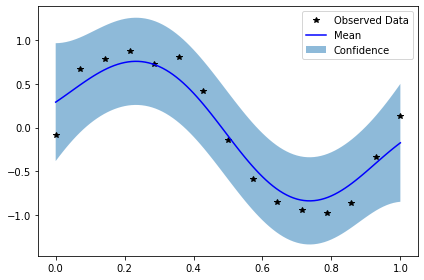

In [40]:
from matplotlib import pyplot as plt
%matplotlib inline

# Initialize plot
f, ax = plt.subplots(1, 1, figsize=(6, 4))
# test model on 101 regular spaced points on the interval [0, 1]
test_X = torch.linspace(0, 1, 101, dtype=dtype, device=device)
# no need for gradients
with torch.no_grad():
    # compute posterior
    posterior = model.posterior(test_X)
    # Get upper and lower confidence bounds (2 standard deviations from the mean)
    lower, upper = posterior.mvn.confidence_region()
    # Plot training points as black stars
    ax.plot(train_X.cpu().numpy(), train_Y.cpu().numpy(), 'k*')
    # Plot posterior means as blue line
    ax.plot(test_X.cpu().numpy(), posterior.mean.cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_X.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
ax.legend(['Observed Data', 'Mean', 'Confidence'])
plt.tight_layout()